In [1]:
import beamtest_analysis_helper as helper
from glob import glob
from pathlib import Path
from datetime import datetime, timedelta
import pandas
import re
from natsort import natsorted
import copy

In [ ]:
setup_labels = {
    'Pair2': 'ET2 EPIR FBK UFSD4 W9 3-5',   # Started with one setup per chip
    'Pair3': 'ET2 EPIR FBK UFSD4 W10 5-5',  # Started with one setup per chip
    'CERNTrigger': 'ET2 EPIR FBK UFSD4 W13 4-5',
}

basedir = Path('/run/media/daq/T7/BumpBondedCosmicRuns/')


run_format = {
    'run_id': [],
    'setup': [],
    'name': [],
    'chip': [],
    'rel_path': [],
    'num_files': [],
    'start': [],
    'stop': [],
    'events': [],
    'offset': [],
    'preamplifier': [],
    'high_voltage': [],
}
run_part_format = {
    'run_id': [],
    'part_idx': [],
    'start': [],
    'stop': [],
    'events': [],
}
data_format = {
    'evt': [],
    'board': [],
    'col': [],
    'row': [],
    'toa': [],
    'tot': [],
    'cal': [],
    '': [],
}
events_per_parquet = 10**4

run_db_file = basedir/'run_db.sqlite'
if run_db_file.exists() and run_db_file.is_file():
    run_db = pandas.read_sql()  # load run_db from sqlite
    run_part_db = pandas.read_sql()  # load part_db from sqlite
else:
    run_db = pandas.DataFrame(run_format)
    run_db['run_id'] = run_db['run_id'].astype(int)
    run_db['num_files'] = run_db['num_files'].astype(int)
    run_db['events'] = run_db['events'].astype(int)
    run_db['offset'] = run_db['offset'].astype(int)

    run_part_db = pandas.DataFrame(run_part_format)
    run_part_db['run_id'] = run_part_db['run_id'].astype(int)
    run_part_db['part_idx'] = run_part_db['part_idx'].astype(int)
    run_part_db['events'] = run_part_db['events'].astype(int)

for key in run_format:
    run_format[key] = [None]

run_re = r'^SelfTrigger_(.+)_HV(\d+)_Readout_offset(\d+)_(.+)_cosmics_loop_(\d+)$'
run_name_re = r'^(.+)_Array_Test_Results_(.+)$'

setup_runs = {}
for setup_name in setup_labels:
    setup_runs[setup_name] = []
    chip_dir = basedir / setup_name
    for dir in chip_dir.glob('*_Array_Test_Results_*'):
        if 'Overnight' not in dir.name:  # Just for safety when testing
            continue

        run_name_match = re.match(run_name_re, dir.name)
        run_name_groups = run_name_match.groups()
        run_name = f'{run_name_groups[0]}_{run_name_groups[1]}'

        # run_dir_info = dir.stat()
        # run_dir_time = run_dir_info.st_mtime  # This time is probably not useful

        run_id = int(len(run_db))
        start = None
        stop = start
        run_files = 0
        run_events = 0

        for part in dir.iterdir():
            match = re.match(run_re, part.name)
            if match is None:
                continue
            match_groups = match.groups()

            run_chip = match_groups[0]
            run_hv = float(match_groups[1])
            run_offset = int(match_groups[2])
            run_preamp = match_groups[3]
            part_idx = int(match_groups[4])
            
            part_info = part.stat()
            part_start = part_info.st_mtime
            if start is None:
                start = part_start
                stop = start
            if part_start > stop:
                stop = part_start
            if part_start < start:
                start = part_start
            part_start = datetime.fromtimestamp(part_start)
            part_stop = part_start + timedelta(minutes=5)

            part_events = 0

            print(part)
            for file_path in part.iterdir():
                print(file_path)
                if file_path.suffix != ".dat":  # If file is not a dat file
                    continue
                if "TDC_Data_translated" != file_path.name[:19]:  # If not a translated file
                    continue
                with file_path.open('r') as file:
                    for line in file:
                        print(line)
                        break

            run_part_data = copy.deepcopy(run_part_format)

            run_part_data['run_id'] = [run_id]
            run_part_data['part_idx'] = [part_idx]
            run_part_data['start'] = [part_start]
            run_part_data['stop'] = [part_stop]
            run_part_data['events'] = [part_events]

            new_df = pandas.DataFrame(run_part_data)
            run_part_db = pandas.concat((run_part_db, new_df), ignore_index = True)
            del new_df
            del run_part_data

            break  # Just for safety when testing

        if start is None:
            continue

        start = datetime.fromtimestamp(start)
        stop = datetime.fromtimestamp(stop) + timedelta(minutes=5)

        run_data = copy.deepcopy(run_format)

        run_data['run_id'] = [run_id]
        run_data['setup'] = [setup_name]
        run_data['name'] = [run_name]
        run_data['chip'] = [run_chip]
        run_data['rel_path'] = [dir.name]
        run_data['num_files'] = [run_files]
        run_data['start'] = [start]
        run_data['stop'] = [stop]
        run_data['events'] = [run_events]
        run_data['offset'] = [run_offset]
        run_data['preamplifier'] = [run_preamp]
        run_data['high_voltage'] = [run_hv]

        new_df = pandas.DataFrame(run_data)
        run_db = pandas.concat((run_db, new_df), ignore_index = True)
        del new_df
        del run_data

run_db
run_part_db

# Save run_db into sqlite

In [2]:
chip_labels = [0]
chip_figtitles = ['ET2 EPIR FBK UFSD4 W10 5-5']  # Pair 3
#chip_figtitles = ['ET2 EPIR FBK UFSD4 W9 3-5']  # Pair 2
chip_figtitles = ['ET2 EPIR FBK UFSD4 W13 4-5']  # CERN Trigger
# chip_figtitles = ['ET2 Barcelona FBK UFSD4 W12 2-3']  # W12 2-3
#chip_figtitles = ['ET2 Barcelona FBK UFSD4 W12 5-3']  # W12 5-3
#chip_figtitles = ['ET2 Barcelona FBK UFSD4 W15 3-4']  # W15 3-4
#chip_figtitles = ['ET2 EPIR FBK Pair 4']  # Pair 4
#chip_figtitles = ['ET2 Barcelona FBK UFSD4 W12 5-5']  # W12 5-5
chip_fignames = chip_figtitles
chip_names = chip_figtitles
fig_path = './'

In [3]:
files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/Pair2/2023-10-31_Array_Test_Results_Overnight/*/*.dat')
files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/CERNTrigger/2023-11-12_Array_Test_Results_Overnight/*/*.dat')
#files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/Pair3/2023-11-10_Array_Test_Results_Weekend/*/*.dat')
#files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/W12_2_3/2023-11-18_Array_Test_Results_Weekend/*/*.dat')
#files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/W12_5_3/2023-11-20_Array_Test_Results/*/*.dat')
#files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/W15_3_4/2023-11-21_Array_Test_Results_Overnight/*/*.dat')
#files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/Pair4/2023-11-27_Array_Test_Results_Overnight/*/*.nem')
#files = glob('/run/media/daq/T7/BumpBondedCosmicRuns/W12_5_5/2023-11-28_Array_Test_Results_1hour/*/*.nem')
#files = glob('/run/media/daq/T7/2023-11-01_Array_Test_Results/*/*.dat')

#files = natsorted(files)

#files = files[30:90]

df = helper.toSingleDataFrame(files=files)
#df = helper.toSingleDataFrame_newEventModel(files=files)
#helper.toSingleDataFramePerDirectory('/run/media/daq/T7/2023-10-28_Array_Test_Results', 'SelfTrigger_ET2_EPIR_Pair3_HV300_Readout_offset10_lowpower_cosmics_loop_*')

In [4]:
df

,evt,board,row,col,toa,tot,cal
0,0.0,0.0,15.0,9.0,699.0,275.0,199.0
1,0.0,0.0,15.0,10.0,668.0,232.0,197.0
2,1.0,0.0,11.0,6.0,863.0,155.0,215.0
3,2.0,0.0,1.0,13.0,454.0,192.0,199.0
4,3.0,0.0,11.0,4.0,150.0,211.0,203.0
...,...,...,...,...,...,...,...
3762,3739.0,0.0,15.0,14.0,570.0,17.0,192.0
3763,3740.0,0.0,13.0,15.0,606.0,21.0,193.0
3764,3741.0,0.0,14.0,12.0,575.0,9.0,195.0
3765,3742.0,0.0,13.0,15.0,605.0,5.0,193.0


# Inclusive

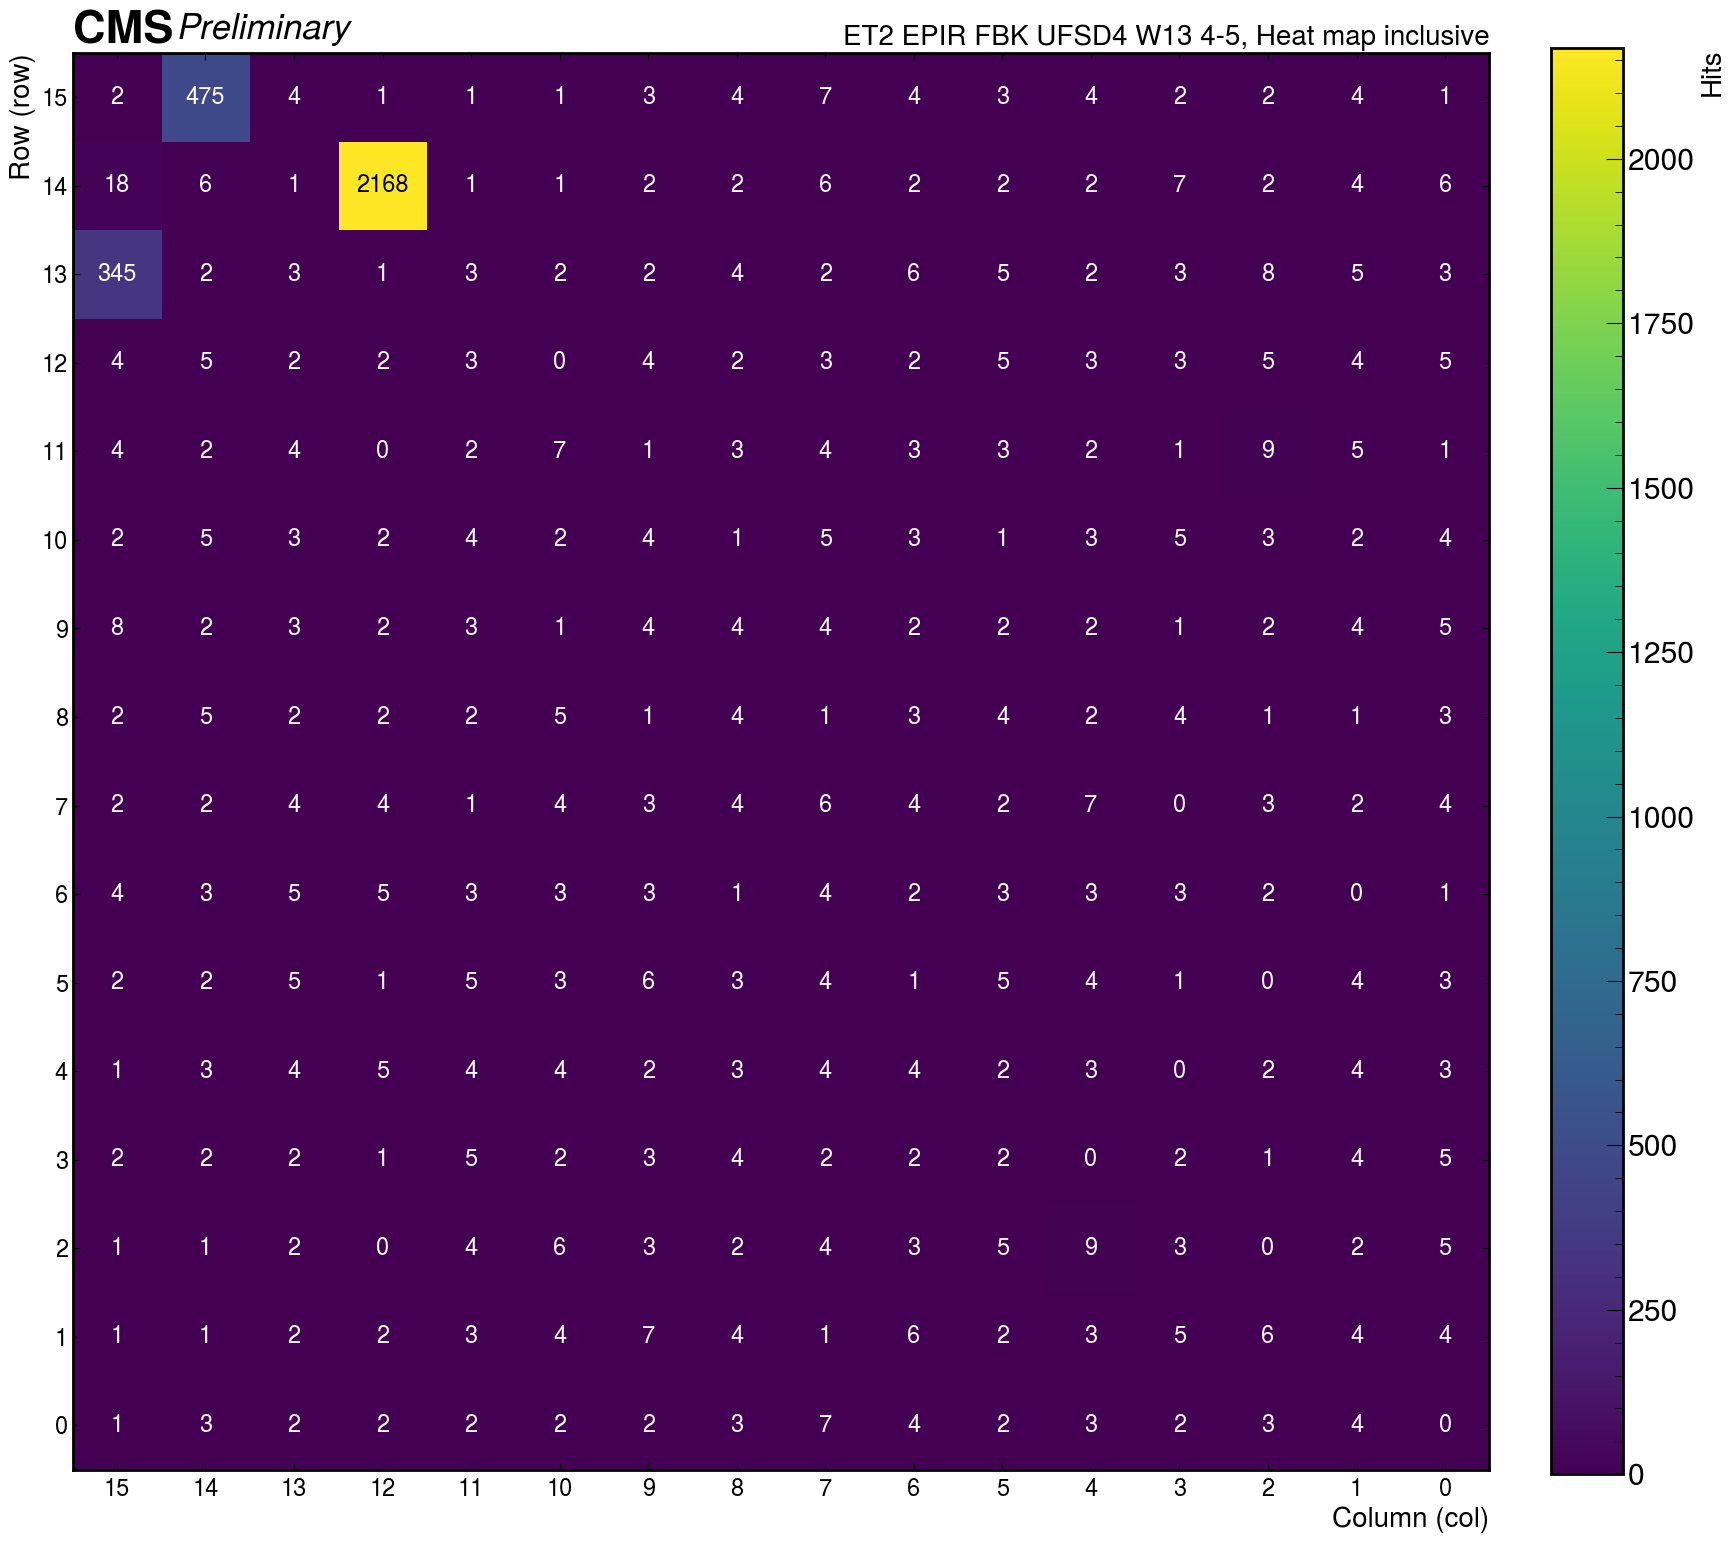

In [5]:
helper.making_heatmap_byPandas(df, chip_labels, chip_figtitles, "inclusive")

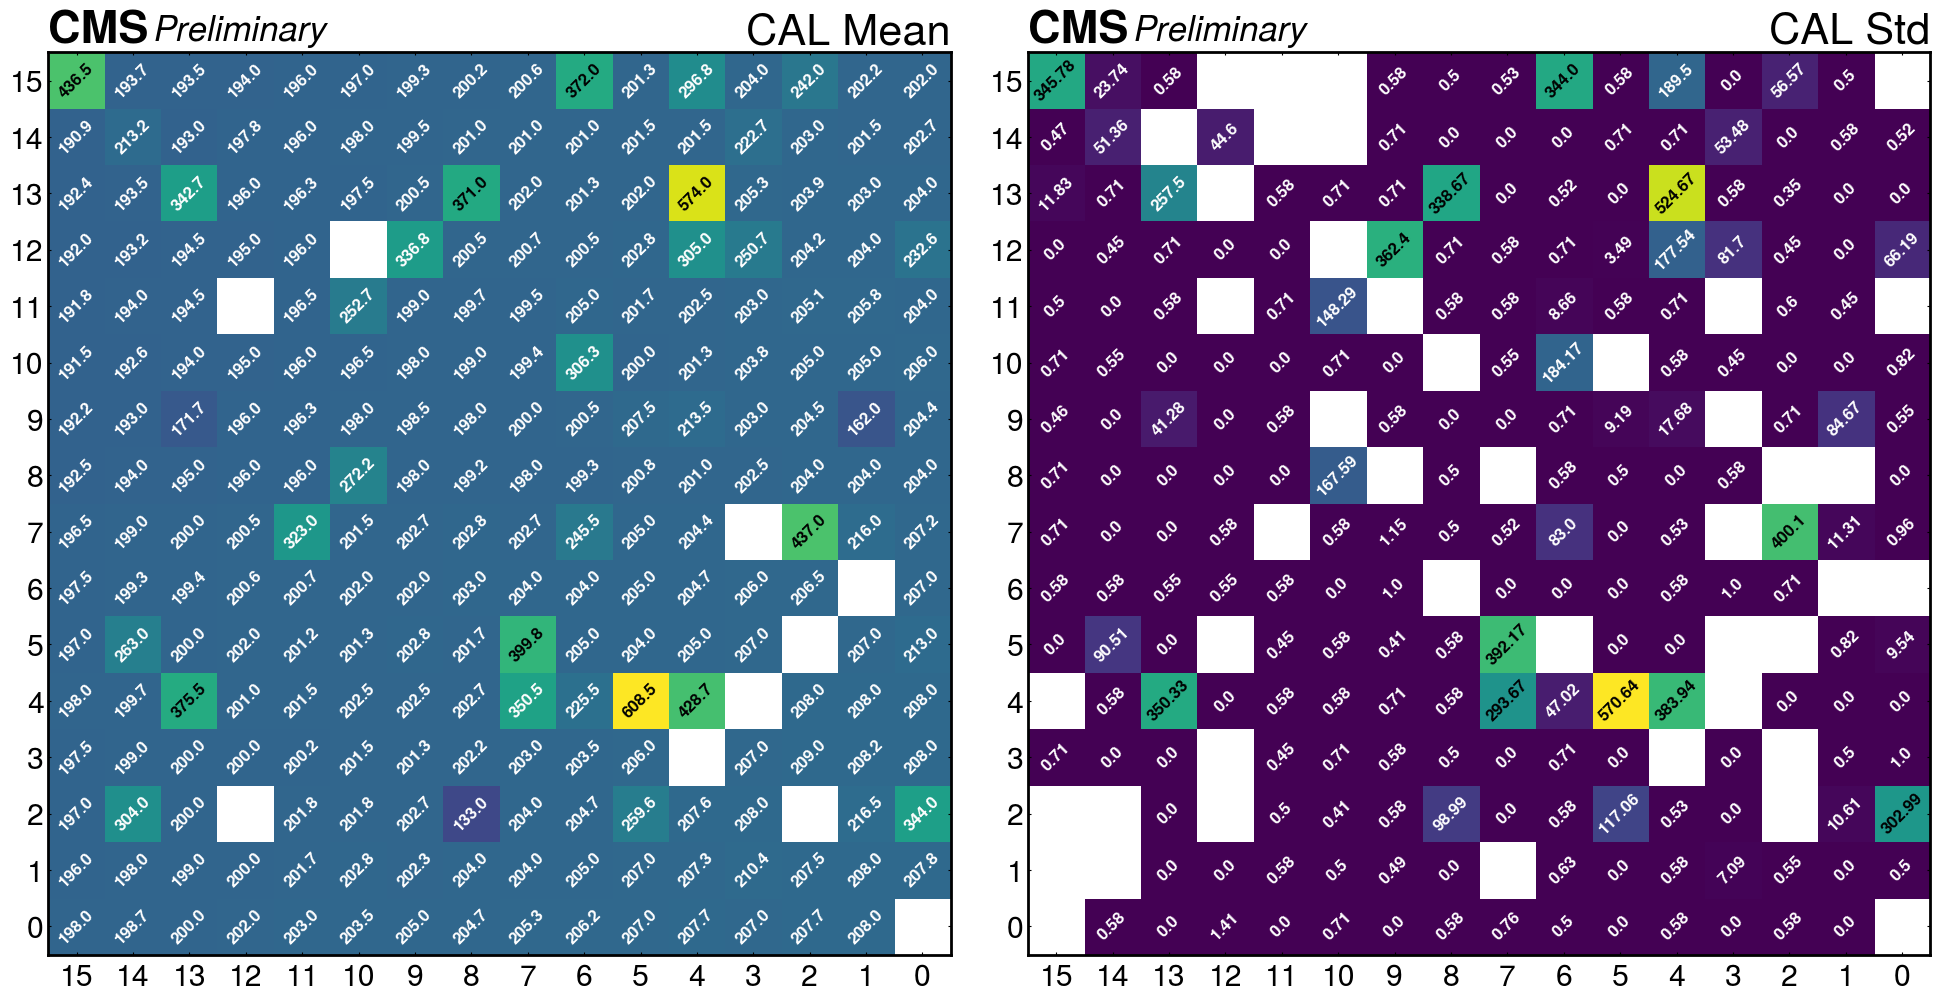

In [6]:
helper.make_TDC_summary_table(df, chip_labels, "cal")

In [ ]:
helper.make_TDC_summary_table(df, chip_labels, "toa")

In [ ]:
helper.make_TDC_summary_table(df, chip_labels, "tot")

In [ ]:
h_inclusive = helper.return_hist(df, chip_names, chip_labels)
helper.make_pix_inclusive_plots(h_inclusive, chip_names[0], chip_fignames[0], chip_figtitles[0], 
                                fig_path, save=False, show=True, tag="inclusive", title_tag=", inclusive", slide_friendly=True)

# Plot selected pixels

Useful for plotting a single noisy pixel for instance, or a group of pixels

In [ ]:
selected_pixels = [
#    (10, 8),
#    (12, 14),
#    (3, 10),
#    (2, 10),
#    (4, 12),
#    (5, 13),
#    (3, 11),
    (15, 14),
#    (15, 12),
#    (12, 14),
#    (13, 14),
#    (2, 15),
]

print("Number of Selected Pixels:", len(selected_pixels))

df_selected = df.copy()

for pixel in selected_pixels:
    df_selected = df_selected.loc[((df_selected['row'] == pixel[0]) & (df_selected['col'] == pixel[1]))].copy()

In [ ]:
helper.making_heatmap_byPandas(df_selected, chip_labels, chip_figtitles, "selected")

In [ ]:
helper.make_TDC_summary_table(df_selected, chip_labels, "cal")

In [ ]:
helper.make_TDC_summary_table(df_selected, chip_labels, "toa")

In [ ]:
helper.make_TDC_summary_table(df_selected, chip_labels, "tot")

In [ ]:
h_selected = helper.return_hist(df_selected, chip_names, chip_labels)
helper.make_pix_inclusive_plots(h_selected, chip_names[0], chip_fignames[0], chip_figtitles[0], 
                                fig_path, save=False, show=True, tag="selected", title_tag=", selected", slide_friendly=True)

# Mask selected pixels

Remove the selected pixels from processing

In [ ]:
masked_pixels = [
#    (10, 8),
#    (12, 14),
#    (3, 10),
#    (2, 10),
#    (4, 12),
#    (3, 11),
#    (15, 11),
#    (5, 13),
#    (15, 12),
#    (12, 14),
#    (14, 15),
#    (15, 13),
#    (15, 14),
    (15, 14),
    (14, 12),
    (13, 15),
    #(2, 15),
#    (13, 14),
#    (2, 15),
]

print("Number of Masked Pixels:", len(masked_pixels))

df_masked = df.copy()

for pixel in masked_pixels:
    df_masked = df_masked.loc[~((df_masked['row'] == pixel[0]) & (df_masked['col'] == pixel[1]))].copy()

print("Number of Events:",len(df_masked))


In [ ]:
helper.making_heatmap_byPandas(df_masked, chip_labels, chip_figtitles, "masked")

In [ ]:
helper.make_TDC_summary_table(df_masked, chip_labels, "cal")

In [ ]:
helper.make_TDC_summary_table(df_masked, chip_labels, "toa")

In [ ]:
helper.make_TDC_summary_table(df_masked, chip_labels, "tot")

In [ ]:
h_masked = helper.return_hist(df_masked, chip_names, chip_labels)
helper.make_pix_inclusive_plots(h_masked, chip_names[0], chip_fignames[0], chip_figtitles[0], 
                                fig_path, save=False, show=True, tag="masked", title_tag=", masked", slide_friendly=True)

# Filter Event

For applying cuts to the TOT, TOA or CAL

In [ ]:
df_filtered = df.copy()

df_filtered = df_filtered.loc[(df_filtered['tot'] > 50) & (df_filtered['tot'] < 10000)].copy()
#df_filtered = df_filtered.loc[(df_filtered['cal'] > 194) & (df_filtered['tot'] < 10000)].copy()
#df_filtered = df_filtered.loc[(df_filtered['cal'] < 200) & (df_filtered['tot'] < 10000)].copy()
#df_filtered = df_filtered.loc[(df_filtered['cal'] > 194) & (df_filtered['cal'] < 200)].copy()

pixels = [
#    (5, 13),
#    (3, 11),
#    (15, 11),
]

for pixel in pixels:
    df_filtered = df_filtered.loc[~((df_filtered['row'] == pixel[0]) & (df_filtered['col'] == pixel[1]))].copy()

In [ ]:
helper.making_heatmap_byPandas(df_filtered, chip_labels, chip_figtitles, "filtered")

In [ ]:
helper.make_TDC_summary_table(df_filtered, chip_labels, "cal")

In [ ]:
helper.make_TDC_summary_table(df_filtered, chip_labels, "toa")

In [ ]:
helper.make_TDC_summary_table(df_filtered, chip_labels, "tot")

In [ ]:
h_filtered = helper.return_hist(df_filtered, chip_names, chip_labels)
helper.make_pix_inclusive_plots(h_filtered, chip_names[0], chip_fignames[0], chip_figtitles[0], 
                                fig_path, save=False, show=True, tag="masked", title_tag=", masked", slide_friendly=True)

# Save Data

In [ ]:
#df.to_csv('ET2_EPIR_FBK_Pair4_single_cosmic.csv', index=False)
df.to_feather('test.feather')